# PHT EB Catalog - PHT participants

- this notebook focuses on report the behavior of PHT participants
- Thus it primarily works on PHT subject level (rather than TIC level)

In [1]:
from importlib import reload

import numpy as np
import pandas as pd
from IPython.display import display, HTML

import matplotlib
from matplotlib import pyplot as plt

import catalog
import catalog_stats
import user_stats
import dashboard_utils

display(HTML("<style>.container { width:99% !important; }</style>"))
matplotlib.style.use("seaborn-notebook");

In [2]:
def sector_group_func1(sector):
    if sector <= 13:
        return "01-13"  # year 1
    elif sector <= 26:
        return "14-26"  # year 2
    elif sector <= 39:
        return "27-39"  # year 3
    else:
        return "others"

def sector_group_func2(sector):
    if sector <= 9:
        return "01-09"  # use the zoom-in UI1, sector 9 with UI2 and UI2
    elif sector <= 19:
        return "10-19"
    elif sector <= 29:
        return "20-29"
    elif sector <= 39:
        return "30-39"
    else:
        return "others"  # should not happen

sector_groups = ["01-09", "10-19", "20-29", "30-39"]
df = catalog.create_pht_eb_subj_catalog(sector_group_func=sector_group_func2)
print("Num. of subjects in the catalog:", len(df))

Num. of subjects in the catalog: 28092


## Tagging accuracy changes over time

- The proxy accuracy among subjects tagged by more than 3 users (`eb_score >=3`) does not change much over time.
- There might in fact be some *decrease* in sectors 30-39, down to <span style="background: rgba(255,255,0, 0.8);">91.8%</span>
- The proportion of subjects with `eb_score >=3` has incresaed, from <span style="background: rgba(255,168,0, 0.5);">19.5%</span> in sectors 1-9 up to <span style="background: rgba(255,168,0, 0.5);">39.2%</span> in sectors 30-39

In [3]:
max_eb_score =3
catalog_stats.add_eb_score_group(df, group_min=0, group_max=max_eb_score, recalc_if_exists=True)


sector_group_reports, sector_group_stylers = [], []
for i, sector_group in enumerate(sector_groups):
    report, styler = catalog_stats.pivot_by_eb_score_group(df[df["sector_group"] == sector_group], 
                                                           calc_totals_pct_col=True,
                                                           also_return_styler=True)
    # abbreviate is_eb_catalog, eb_score_group to fit the screen space
    styler.columns.names = [None, None, "is_eb"]
    styler.index.name = "score"

    # highlight the best
    selector_proxy_accuracy = (f"0{max_eb_score}+", ("count", "tic_id", "T/(T+F)"))
    styler = styler.applymap(lambda x: "background: rgba(255, 255, 0, 0.8)", subset=selector_proxy_accuracy)
    selector_totals_pct = (f"0{max_eb_score}+", ("count", "tic_id", "Totals %"))
    styler = styler.applymap(lambda x: "background: rgba(255, 168, 0, 0.5)", subset=selector_totals_pct)
    styler = styler.set_caption(f"Sectors {sector_group}")
    
    sector_group_reports.append(report)
    sector_group_stylers.append(styler)

dashboard_utils.n_columns(sector_group_stylers)

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

### Per-sector proxy accuracy

- There seems to have some correlation between proxy accuracy and number of tagged subjects in a sector.
- In particular, the drop in proxy accuracy coinicdes with the number of subjects tagged (sectors 11, 28).
  - The reverse is not necessarily true, however (e.g., sector 22).
  - It is unclear if is just coincidental or there is some underly reason.

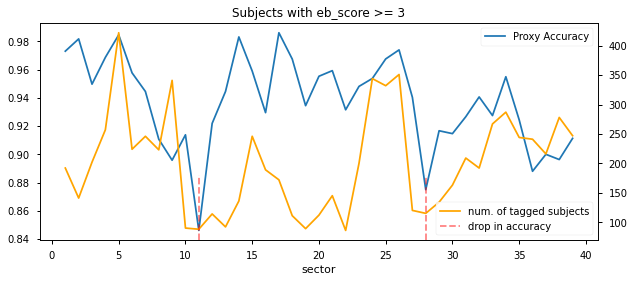

In [70]:
report, styler = catalog_stats.pivot_by_eb_score_group(df[df["eb_score"] >= 3], 
                                                       index="sector",
                                                       calc_totals_pct_col=True,
                                                       also_return_styler=True)
# a subset of per-sector excluding Totals
report = report[report.index != "Totals"].sort_index() 
ax = plt.figure(figsize=(10, 4)).gca()
ax = report.plot(y=("count", "tic_id", "T/(T+F)"), ax=ax, kind="line", legend=False)
ax.legend(["Proxy Accuracy"], loc="upper right")
ax = ax.twinx()  # visually the same plot, but with an independent y-axis
ax = report.plot(y=("count", "tic_id", "Totals"), c="orange", ax=ax, kind="line", legend=False)
ax.axvline(11, ymin=0, ymax=0.3, c="red", alpha=0.5, linestyle="--");
ax.axvline(28, ymin=0, ymax=0.3, c="red", alpha=0.5, linestyle="--");
ax.legend(["num. of tagged subjects", "drop in accuracy"], loc="lower right")
ax.set_title(f"Subjects with eb_score >= {max_eb_score}");

## Top Users' Contributions

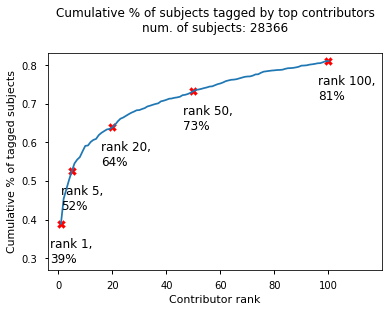

In [3]:
df_top_contrib = user_stats.load_top_users_cum_contributions_from_file()
ax = dashboard_utils.plot_cumulative_user_contributions(df_top_contrib, ranks_to_label=[1, 5, 20, 50, 100]);

## Would user weighting improve proxy accuracy?

- _Individually_, users at lower rank do tend to have worse proxy accuracy
- However, _in aggregate_, when considering the tagging of all users of a TIC with `eb_score`, a cutoff of `eb_score >= 3` does yield a stable and high proxy accuracy, of 92 - 94%.
- There is still room for some user weighting: for `eb_score = 2`, rank 1 and rank 2 users still have decent proxy accuracy, at 92% and 89% respectively.


In [17]:
reload(user_stats)

max_eb_score = 3
df_catalog = dashboard_utils.get_catalog("pht_eb")

result = user_stats.calc_proxy_accuracy_stats_by_rank_group(df_catalog, max_eb_score=max_eb_score);

grid, out1, out2 = dashboard_utils.two_columns(also_return_outputs=True)

with out1:
    ax = result.df_rank_group_proxy_accuracy.plot(kind="bar", x="rank_group", y=f"proxy_accuracy, all")
    ax.set_ylim(0.7, 1.0);
    ax.set_title("Proxy accuracy decreases for lower-ranked users");
    plt.close(1)  # hide the one drawn outside of the gird
    display(ax.get_figure())

with out2:
    ax = result.df_rank_group_proxy_accuracy.plot(kind="bar", x="rank_group", y=f"proxy_accuracy, eb_score >= {max_eb_score}")
    ax.set_ylim(0.70, 1.0);
    ax.set_title("Proxy accuracy quite stable for TICs with eb_score >= 3");
    plt.close(1) # hide the one drawn outside of the gird
    display(ax.get_figure())

display(grid)

GridBox(children=(Output(layout=Layout(border='1px dotted gray')), Output(layout=Layout(border='1px dotted gra…

### Tag Accuracy detailed breakdown by user ranks

- rank 1 / 2 users still have decent proxy accuracy at `eb_score = 2`

In [18]:
display(result.all_styler)  # all users report

for i, styler in enumerate(result.rank_group_stylers):
    if i in [0, 1]:  # special highlight for rank 001, 002 
        selector_proxy_accuracy_eb_score_2 = (f"02", ("count", "tic_id", "T/(T+F)"))
        styler = styler.applymap(lambda x: "background: rgba(255, 255, 0, 0.8)", subset=selector_proxy_accuracy_eb_score_2)        
    display(styler)